<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/tutorials_notebooks_in_class_2024/W13_Topic_Modeling_CTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we will go through Combined Topic Models (CTMs) - which utilizes contextualized embeddings from a Language Model alongside Bag of Words for extracting topics

`Combined = Concat(Contextualize,BoW)`

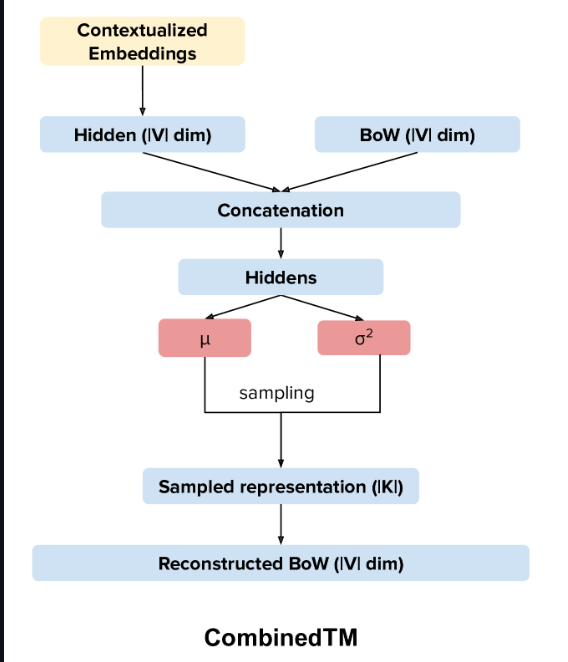

📝❓ How does an Autoencoder work?

📝❓ How does a Variational Autoencoder (VAE) work?

📝❓ Why do we use a VAE for Topic Modeling?

Now we look into Contextualized Topic Models, which uses pre-trained Document representation instead of a plain Bag of Words.

Method developed by [Bianchi et al. 2021](https://aclanthology.org/2021.acl-short.96/).

[A 6min presentation of the paper by one of the authors.](https://underline.io/lecture/25716-pre-training-is-a-hot-topic-contextualized-document-embeddings-improve-topic-coherence)

[Medium Blog](https://towardsdatascience.com/contextualized-topic-modeling-with-python-eacl2021-eacf6dfa576)

Code: [https://github.com/MilaNLProc/contextualized-topic-models](https://github.com/MilaNLProc/contextualized-topic-models)

Tutorial: [https://colab.research.google.com/drive/1fXJjr_rwqvpp1IdNQ4dxqN4Dp88cxO97?usp=sharing](https://colab.research.google.com/drive/1fXJjr_rwqvpp1IdNQ4dxqN4Dp88cxO97?usp=sharing)


In [1]:
%%capture
!pip install -qU contextualized-topic-models pyldavis

### Import Necessary Libraries

In [2]:
import kagglehub
import pandas as pd
import os
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from nltk.corpus import stopwords as stop_words
import nltk
nltk.download('stopwords')
import re
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***Important - Executing the import below (WhiteSpacePreprocessing) will produce an error on the first run. Executing it again mitigates the error. This is probably due to some caching issues with contextualized_topic_models package***

In [3]:
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing

ImportError: cannot import name 'triu' from 'scipy.linalg.special_matrices' (/usr/local/lib/python3.10/dist-packages/scipy/linalg/special_matrices.py)

In [4]:
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing

In [5]:
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords

### Download Dataset

In [6]:
# Download latest version
path = kagglehub.dataset_download("therohk/million-headlines")
df = pd.read_csv(os.path.join(path, 'abcnews-date-text.csv'))

# Inspect Dataset
print(df['headline_text'].iloc[0])

# Select only 100000 samples
df = df.sample(n=100000, random_state=42)
df.head()

100%|██████████| 21.4M/21.4M [00:01<00:00, 19.1MB/s]

Extracting files...


aba decides against community broadcasting licence


,publish_date,headline_text
1144371,20181017,virtual reality trial ahead of fire season in ...
282871,20070131,farmers prepare for ec funding
895099,20140810,the sunday inquisition august 10
764744,20130221,news csg reax
894276,20140806,rosetta spacecraft on final approach to comet ...


### Preprocess

We need preprocessed text for Bag of Words - so the vocabulary space does not explode, and unpreprocessed text for getting embeddings from Language Model as they provide better context  

In [7]:
# Take only 10k samples for faster training
documents = df['headline_text'].apply(lambda line: line.strip()).tolist()[:10000]
stopwords = list(stop_words.words("english"))

sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

In [8]:
# Take a look at the preprocessed documents

preprocessed_documents[:5]

['reality trial ahead fire season south australia',
 'farmers prepare funding',
 'sunday august',
 'news csg',
 'final approach']

### Training

Here we use [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) model which embeds sentences & paragraphs to a 768 dimensional dense vector space


In [9]:
# Prepare dataset for training - passing both preprocessed data for contextual representation and unpreprocessed data for bow
tp = TopicModelDataPreparation("all-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
# Check Vocab
tp.vocab[:10]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

array(['abattoir', 'abbott', 'abc', 'aboriginal', 'abuse', 'academic',
       'accc', 'access', 'accident', 'accused'], dtype=object)

In [10]:
'''
bow_size = vocab_size
contextual_size = embedding dimension
n_components = number of topics
num_epochs = epochs for training
'''
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=5, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [97920/98240]	Train Loss: 28.236137190675425	Time: 0:00:02.579012: : 10it [00:30,  3.00s/it]
100%|██████████| 154/154 [00:02<00:00, 68.73it/s]


### Get Topic Lists

In [11]:
# Look at the top 10 words in each topic  - We had 5 topics
ctm.get_topic_lists(10)

[['world',
  'west',
  'day',
  'australia',
  'final',
  'league',
  'wins',
  'one',
  'south',
  'coast'],
 ['govt',
  'water',
  'council',
  'health',
  'plan',
  'urged',
  'government',
  'indigenous',
  'public',
  'tax'],
 ['china',
  'us',
  'iraqi',
  'market',
  'trump',
  'kills',
  'attacks',
  'soldiers',
  'fighting',
  'warns'],
 ['pm',
  'election',
  'abc',
  'farmers',
  'country',
  'hour',
  'news',
  'new',
  'labor',
  'interview'],
 ['police',
  'man',
  'crash',
  'murder',
  'found',
  'court',
  'guilty',
  'woman',
  'dead',
  'accused']]

### Visualizing the topics

In [12]:
import pyLDAvis as vis

In [13]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 154/154 [00:02<00:00, 53.77it/s]


📝❓ Can you guess the topics?

📝❓ Is it more coherent than LDA?


## Multilingual Setting

Here, we will use [polynews](https://huggingface.co/datasets/aiana94/polynews) dataset - consisting of news headlines from 77 languages. We select the following languages - German, French, Italian and English for analysis.

### Download Dataset

In [18]:
# Get De dataset
df_de = pd.read_parquet("hf://datasets/aiana94/polynews/data/deu_Latn/train.parquet.gzip")
df_de['lang'] = ['de']*df_de.shape[0]
print(df_de.shape)
df_de.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(145484, 3)


,text,provenance,lang
0,BBC erklärt eigenen Beitrag über Entschädigung...,wikinews,de
1,SS-Lagerkommandant Schwammberger gestorben,wikinews,de
2,Verkauf von Telefonen mit voreingestellter Tel...,wikinews,de
3,Vorabversion von Thunderbird 1.0 freigegeben,wikinews,de
4,Neue Dinosaurierart in Brasilien entdeckt,wikinews,de


In [19]:
# Get French dataset
df_french = pd.read_parquet("hf://datasets/aiana94/polynews/data/fra_Latn/train.parquet.gzip")
df_french['lang'] = ['french'] * df_french.shape[0]
print(df_french.shape)
df_french.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(481117, 3)


,text,provenance,lang
0,Christophe Hondelatte débarqué du journal de l...,wikinews,french
1,"Élections irakiennes en territoires étrangers,...",wikinews,french
2,La Chine achète 60 Boeing 787 Dreamliners,wikinews,french
3,Premier bilan des élections irakiennes,wikinews,french
4,Apple dévoile ses nouveaux PowerBook,wikinews,french


In [20]:
# Get Italian dataset
df_it = pd.read_parquet("hf://datasets/aiana94/polynews/data/ita_Latn/train.parquet.gzip")
df_it['lang'] = ['italian'] * df_it.shape[0]
print(df_it.shape)
df_it.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(163396, 3)


,text,provenance,lang
0,Confermate le elezioni in Liguria,wikinews,italian
1,Domenica e lunedì si vota per le elezioni ammi...,wikinews,italian
2,"Papa gravissimo, ma cosciente e sereno",wikinews,italian
3,Peggiorate le condizioni del Papa,wikinews,italian
4,Rinviate le elezioni in Basilicata,wikinews,italian


In [21]:
# Get English dataset
df_eng = pd.read_parquet("hf://datasets/aiana94/polynews/data/eng_Latn/train.parquet.gzip")
df_eng['lang'] = ['eng'] * df_eng.shape[0]
print(df_eng.shape)
df_eng.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(981430, 3)


,text,provenance,lang
0,President of China lunches with Brazilian Pres...,wikinews,eng
1,Palestinians to elect new president on January 9,wikinews,eng
2,Brazilian delegation returns from Arafat funeral,wikinews,eng
3,Hearing begins over David Hookes death,wikinews,eng
4,Iran close to decision on nuclear program,wikinews,eng


In [23]:
# Select 2,500 samples from each dataset - for faster implementation and make dataset balanced
# Concatenate all datasets
df_de_sampled = df_de.sample(n=2500, random_state=42)
df_french_sampled = df_french.sample(n=2500, random_state=42)
df_it_sampled = df_it.sample(n=2500, random_state=42)
df_eng_sampled = df_eng.sample(n=2500, random_state=42)
df = pd.concat([df_de_sampled, df_french_sampled, df_it_sampled, df_eng_sampled])
df = df.sample(frac=1, random_state=42)
print(df.shape)
# Check distribution of languages
print(df[['text','lang']].groupby(by='lang').count())
# Inspect first 10 rows
df.head(10)

(10000, 3)
         text
lang         
de       2500
eng      2500
french   2500
italian  2500


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,provenance,lang
32060,E vivere per la strada è stato proprio il dest...,globalvoices,italian
433589,Bahrein : Qu'est- ce que signifie le terme « M...,globalvoices,french
128257,Ich weiß weder wo ich meine Gefühle begraben h...,globalvoices,de
100171,Modern Progressive Khmer mentionne l'occupatio...,globalvoices,french
447164,Bien que le fait se soit déjà produit — la vic...,globalvoices,french
89100,Ma con un numero di liste elettorali che va ol...,globalvoices,italian
97175,Interessierte können sich ohne den Nachweis üb...,globalvoices,de
132391,Si è poi scoperto che aveva lasciato un messag...,globalvoices,italian
72834,"Foto del Manila Collegian, utilizzata nel risp...",globalvoices,italian
35309,Ende August hatte er den letzten der sechs Che...,wmtnews,de


### Preprocess

*Note that we pass only the stopwords list to CTM's preprocessing function and not preprocess through our custom function: this is required because we need the unpreprocessed documents for better quality embeddings while simultaneously reducing the vocabulary for BoW*

In [24]:
# Lets look at languages supported by NLTK for stopwords
# German, French, Italian and English are present !
# 29 languages supported
from nltk.corpus import stopwords
print(stopwords.fileids())
print(len(stopwords.fileids()))

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']
29


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# Combine all stopwords
documents = df['text'].apply(lambda line: line.strip()).tolist()
stopwords_de = list(stop_words.words("german"))
stopwords_french = list(stop_words.words("french"))
stopwords_italian = list(stop_words.words("italian"))
stopwords_english = list(stop_words.words("english"))
stopwords = stopwords_de + stopwords_french + stopwords_italian + stopwords_english

# Remove Stopwords
sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Take a look at the preprocessed documents
preprocessed_documents[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['vivere strada stato proprio',
 'tod mutter weiterhin revolution',
 'apres janvier',
 'bien fait deja produit victoire peuple province plusieurs autres citoyens exemple liste weibo raison plusieurs plusieurs fait quasi entre lance leurs leurs blogs',
 'numero liste elettorali va oltre numero elezioni cose liste elettorali']

### Training

Here we use [paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) model, a multilingual sentence transformer model trained on 50+ languages - converts the document into 768 dimensional embedding

In [27]:
# Prepare dataset for training - passing both preprocessed data for contextual representation and unpreprocessed data for bow
tp = TopicModelDataPreparation("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
# Check Vocab
tp.vocab[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

array(['ab', 'abitanti', 'able', 'abord', 'acces', 'access', 'accesso',
       'accord', 'according', 'accordo'], dtype=object)

In [28]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=5, num_epochs=10)
ctm.fit(training_dataset) # run the model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Epoch: [10/10]	 Seen Samples: [93440/94040]	Train Loss: 38.22926631039136	Time: 0:00:02.629529: : 10it [00:29,  2.94s/it]
100%|██████████| 147/147 [00:02<00:00, 64.39it/s]


In [29]:
# Look at the top 10 words in each topic  - We had 5 topics
ctm.get_topic_lists(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['photo',
  'championnat',
  'calcio',
  'image',
  'immagine',
  'creative',
  'giornata',
  'ligue',
  'serie',
  'flickr'],
 ['blog',
  'voices',
  'global',
  'social',
  'video',
  'media',
  'internet',
  'post',
  'online',
  'site'],
 ['paese',
  'governo',
  'diritti',
  'piu',
  'country',
  'menschen',
  'fur',
  'umani',
  'people',
  'viele'],
 ['would',
  'one',
  'quando',
  'minister',
  'pouvoir',
  'sagte',
  'chose',
  'va',
  'office',
  'konnte'],
 ['ete',
  'plus',
  'pendant',
  'cette',
  'deux',
  'gouvernement',
  'wurde',
  'avoir',
  'contre',
  'encore']]

### Visalizing the topics

In [30]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 147/147 [00:03<00:00, 39.08it/s]
